In [1]:
%matplotlib inline
import numpy as bp
import matplotlib.pylab as plt

# Goal of this module 

1. Understand the importance of the Riemann problem as solution of hyperbolic system in general and for the Euler equations in particular
2. Understand how the different bits and pieces of a full fluid code fit together, i.e., how it differs (or does not differ) from linear advection and Burger's equation
3. Be able to implement them or to be more precise: Be able to numerically solve the shock tube problem with a second order MUSCL-Hancock scheme that includes 
 - piecewise linear reconstruction with slope limitting (beta limiter: minmod/superbee)
 - an approximate Riemann solver (HLL)
4. Bonus (for free): Read, understand and extend someone else's code


# Preclass assignments
The preclass assignment is again due **midnight before class**.

## Reading

As with the last reading assignments, focus more on the general concepts and less on the specifics of the mathematical derivation.
Also feel free, to reread sections we already covered in previous classes or read additional section (or other references).

### General background
Please read
- 1.1 Introduction to the Euler equations (3p)
- 1.2.2 Equation of state (1p)
- 2.3 Linear hyperbolic systems (10p)
- 4.0 and 4.1 General solution strategy for the Riemann problem for the Euler eqns (4p)

### Background for the implementation below
You'll implement parts of the schemes presented in the following (sub)sections.
I added the corresponding equations numbers for reference in the code (which is generally good pratice).

Please read
- 10.1, 10.2 and 10.3 HLL Riemann solver (7p)
- 10.5.0 and 10.5.1 Wave speed estimation (2p)
- 14.1 Introduction/recap to High–Order and TVD Schemes for Non–Linear Systems (2p)
- 14.2 CFL and Boundary Conditions (1p)
- 14.4.1 The MUSCL–Hancock Scheme (basics) (3p)
- 14.4.3 TVD Version of the Scheme (i.e. slope limiting) (3p)
- 14.4.4 Summary of the MUSCL–Hancock Method (1p)
- 14.7.1 Numerical results for upwind TVD Methods (introduction of the shock tube test case) 
and briefly look at the figures p. 525f
(this is what we eventually want to compute at the end of this module). (1p)

In general, the individual sections are written in a way that they can also be read "backwards" 
if you prefer to have the "big picture" of the implementation in mind while reading.



## Implementation related

1. Compare the structure of the code below with what you read.
2. Prepare the implemenation (that we'll do in class) by adding comments to the pieces labeled "< YOUR CODE HERE >" that
 1. specify the equation number(s) in Toro you plan to implement there
 2. and briefly explain why this equation is to be solved/what it does


## Questions
Please answer the two following questions in this notebook.

- In how far are the Euler equations different from the linear advection equation and Burgers equation?

< YOUR ANSWER HERE>

- In how far does the overall algorithm differ from what we've used so far for solving hyperbolic PDEs?

< YOUR ANSWER HERE>

- Given that you have left and right hand side quantities in (Eq 14.34), why do you need (Eq 14.35) before calling the Riemann solver?

< YOUR ANSWER HERE>

- Do you have any other question(s) that came up during reading or regarding the code?

< YOUR ANSWER HERE >

In [2]:
def plotSolution(x,U):
    """ Plots the primitive quantities of the one dimenional Euler equations
    
    Parameters
    ----------
    x : array_like
        spatial coordinate for the solution
    U : array_like
        Vector of conserved quantities holding state to be plotted
    """
    
    rho, u_x, p = getPrimitiveFromConserved(U)
    
    fig, plots = plt.subplots(2,2)
    
    plots[0][0].plot(x,rho)
    plots[0][1].plot(x,u_x)
    plots[1][0].plot(x,p)
    e = EOS("e_from_p",p = p, rho = rho)
    plots[1][1].plot(x,e)
    
    plots[0][0].set_ylim(0.,1.1)
    plots[0][0].set_ylabel("Density")
    plots[0][1].set_ylabel("Velocity")
    plots[1][0].set_ylabel("Pressure")
    plots[1][1].set_ylabel("Internal en.")
    

In [3]:
def EOS(Type,p = None, e = None, rho = None):
    """ Equation of states
    Relates different thermodynamic quantities to each other and closes the Euler equations.
    Equation of state used here is the gamma law for an ideal gas: e = p/(rho * (gamma - 1)
    
    Parameters
    ----------
    Type : string
        Determines what is calculated from what
        ========== =================================
        e_from_p   Calculates internal energy from pressure
        p_from_e   Calculates pressure from internal energy
    
    p : ndarray, optional
        pressure
    e : ndarray, optional
        internal energy
    rho : optional
        density
    
    Returns
    -------
    out : ndarray
        The requested (by Type) quantity
    """    
    
##############################################
#         < YOUR CODE HERE >
############################################## 
    
    return out
    

In [4]:
def getFlux(U):
    """
    Calculates the flux for the one-dimensional Euler equations
    
    Parameters
    ----------
    U : array_like
        Vector of conserved variables
    
    Returns
    -------
    out : ndarray
        Vector holding the conserved fluxes.
    """
    
##############################################
#         < YOUR CODE HERE >
############################################## 
    
    return F    

In [5]:
def getPrimitiveFromConserved(U):
    """
    Calculates primitive quantities (here: density, velocity and pressure)
    from the conserved quantities.
    
    Parameters
    ----------
    U : array_like
        Vector of conserved variables
    
    Returns
    -------
    out : (ndarray, ndarray, ndarray)
        Tuple holding density, velocity and pressure
    """
    
##############################################
#         < YOUR CODE HERE >
############################################## 
    
    return rho, u_x, p

In [6]:
def getSlope(Type, Delta_imoh, Delta_ipoh, beta = 1., w = 0.):
    """
    Calculates cell centered slope with different limiters.
    
    Parameters
    ----------
    Type : string
        Type of limiter.
        ========== =================================
        unlimited  Slopes are not limited
        beta       The additional parameter determines the slope limiter
    
    Delta_imoh : ndarray
        Vector of finite differences for all quantities at the left cell boundary (i.e. i-1/2)
        Delta[quantity]_i-1/2 =  U[quantity]_i - U[quantity]_i-1
        
    Delta_ipoh : ndarray
        Vector of finite differences for all quantities at the right cell boundary (i.e. i+1/2)
        Delta[quantity]_i+1/2 =  U[quantity]_i+1 - U[quantity]_i        
    
    beta : float, optional
        beta = 1 reproduces minmod slope limiter
        beta = 2 reprodues superbee slope limiter
        see (Eq 14.44) in Toro
        
    w : float, optional
        -1 <= w <= 1
        w = -1 : forward finite differences
        w = 0 : central finite differences
        w = 1 : backward finite differences
        see (Eq. 14.37) in Toro
        
    
    Returns
    -------
    out : ndarray
        Vector of cell centered (limited) slopes
    """
    
    
    if Type == "unlimited":
        
        # calculate unlimited slopes, see (Eq. 13.37)
        Delta_i = 0.5 * (1. + w) * Delta_imoh + 0.5 * (1. - w) * Delta_ipoh
        
    elif Type == "beta":

        Delta_i = np.zeros_like(Delta_imoh)   
        
##############################################
#         < YOUR CODE HERE >
##############################################        
    
    else:
        print("Please use a limited that is implemented...")
        return False
    
    return Delta_i

In [7]:
def Riemann(U_l, U_r):
    """
    Solves the Riemann problem with the HLL approximate Riemann solver
    for the piecewise constant states.
    
    Parameters
    ----------
    U_l : ndarray
        Vector of reconstructed conserved quantities at the left hand side
        of the edges.
    
    U_r : ndarray
        Vector of reconstructed conserved quantities at the right hand side
        of the edges.    
    
    Returns
    -------
    out : ndarray
        Vector of edge centered fluxes
    """
    
##############################################
#         < YOUR CODE HERE >
############################################## 
    
    return F

In [8]:
def MUSCL_Hancock(Uinitial,dx,tEnd,C = 0.8):   
    """
    Solves the Euler equations using a MUSCL-Hanock scheme
    
    Parameters
    ----------
    Uinitial : array_like
        Vector of conserved variables holding the initial conditions
    dx : float
        Width of the cells
    tEnd : float
        Final time of simulation
    C : float, optional
        CFL parameter to be used
        
    Returns
    -------
    out : ndarray
        The solution at the final time.
        
    Notes
    -----
    Assumes 1-d uniform grid with arbitrary size.
    Number of ghost zones is card coded to 2 on each side.    
        
    
    """

    t = 0.
    
    # add two ghost zones on each side of the array
    U = np.empty((Uinitial.shape[0],4 + Uinitial.shape[1]))
    U[:,2:-2] = Uinitial
    
    while t < tEnd:                
        
        # Transmissive boundary conditions
        # see (Eq. 14.6)
        U[:,1] = U[:,2]
        U[:,0] = U[:,3]
        U[:,-1] = U[:,-4]
        U[:,-2] = U[:,-3]
        
        # we (could) use the following variables only for improved readability
        U_i = U[:,1:-1] 
        U_ip1 = U[:,1+1:] 
        U_im1 = U[:,1-1:-2]
        
##############################################
#         < YOUR CODE HERE >
############################################## 
        
        # Use the Riemann solver to obtain the final fluxes from the 
        # intermediate reconstructed states
        F = Riemann(U_l,U_r)     
        
        # Make a conservative update 
        # see (Eq. 14.3)
        U_i[:,1:-1] += dt/dx * (F[:,:-1] - F[:,1:])

        
        t += dt
    # return the solution without the ghost zones
    return U_i[:,1:-1]

In [ ]:
# initial conditions for the shock tube test
# see 14.7 in Toro
N = 100
gamma = 1.4
x0 = 0.3
rho_l = 1.
velx_l = 0.75
p_l = 1.0
rho_r = 0.125
velx_r = 0.
p_r = 0.1

x = np.linspace(0.,1.,N,endpoint=False)
dx = x[1] - x[0]

# U is a vector that holds the conserved variables for
# the one dimension Euler equations, i.e. density, momentum and total energy
U =  np.zeros((3,N))
# these are helper indices for improved readability, 
# i.e. we store density in the first row (index 0) of U etc.
Id_rho = 0
Id_rhoUx = 1
Id_E = 2

# populate initial condition for the conserved variables
U[Id_rho][x <= x0] = rho_l
U[Id_rhoUx][x <= x0] = rho_l * velx_l
U[Id_E][x <= x0] = 0.5 * rho_l * velx_l**2. + rho_l * EOS("e_from_p",p = p_l, rho = rho_l)
U[Id_rho][x > x0] = rho_r
U[Id_rhoUx][x > x0] = rho_r * velx_r
U[Id_E][x > x0] = 0.5 * rho_r * velx_r**2. + rho_r * EOS("e_from_p",p = p_r, rho = rho_r)

In [ ]:
plotSolution(x,U)

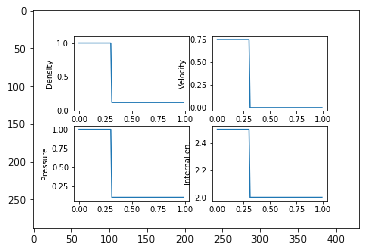

In [9]:
# Solution should look like
imshow(imread("Shock_t-0.png"))

In [ ]:
plotSolution(x,MUSCL_Hancock(U,dx,0.2))

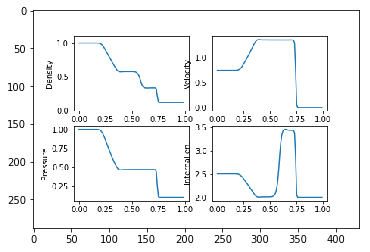

In [10]:
# Solution should look like
plt.imshow(plt.imread("Shock_t-02.png"))